In [40]:
#importing Libs
import pandas as pd
import joblib
from sklearn.cluster import KMeans
import logging
import os


In [41]:
# ----- CONFIG -----
MODEL_PATH = "models/kmeans_model.pkl"
REQUIRED_COLUMNS = ["Total_Weight", "Total_Volume", "Urgent_Flag", "Delivery_Window_Days"]
N_CLUSTERS = 8
LOG_FILE = "logs/ml_cluster_predict.log"

# ----- LOGGING SETUP -----
os.makedirs("logs", exist_ok=True)
logging.basicConfig(
    filename=LOG_FILE,
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s"
)

# Create model directory if it doesn't exist
os.makedirs("models", exist_ok=True)


In [42]:
def load_or_train_model(df):
    if os.path.exists(MODEL_PATH):
        logging.info("📦 Model found. Loading from disk...")
        return joblib.load(MODEL_PATH)

    logging.info("🔧 Training new KMeans model...")
    print("🔧 Training new KMeans model...")
    
    model = KMeans(n_clusters=N_CLUSTERS, random_state=42)
    model.fit(df[REQUIRED_COLUMNS])
    joblib.dump(model, MODEL_PATH)
    logging.info("✅ Model trained and saved.")
    return model


In [43]:
def predict_clusters(input_df: pd.DataFrame) -> pd.DataFrame:
    try:
        # Validate columns
        for col in REQUIRED_COLUMNS:
            if col not in input_df.columns:
                raise ValueError(f"Missing required column: {col}")
        
        model = load_or_train_model(input_df)

        predictions = model.predict(input_df[REQUIRED_COLUMNS])
        input_df["ML_Cluster_Label"] = predictions

        logging.info(f"✅ Prediction complete. Rows processed: {len(input_df)}")
        return input_df

    except Exception as e:
        logging.error(f"❌ Prediction failed: {str(e)}")
        raise


In [44]:

# sample_path = "../../../DataSets/projectplancluster/subcluster_handeling_output.csv"


sample_path = r"C:\Users\Administrator\Desktop\Python\ML\DataSets\projectplancluster\subcluster_handling_output.csv"

products_path = r"C:\Users\Administrator\Desktop\Python\ML\DataSets\RawDataSets\products\products.csv"

import pandas as pd
from datetime import datetime

# === Load files ===
assignments = pd.read_csv(sample_path)
product_info = pd.read_csv(products_path)  # Should contain 'Product_ID' and 'Manufacture_Date'

# === Preprocess dates ===
assignments["Delivery_Window"] = pd.to_datetime(assignments["Delivery_Window"], errors='coerce')
product_info["Manufacture_Date"] = pd.to_datetime(product_info["Manufacture_Date"], errors='coerce')

# === Merge manufacture date using Product_ID ===
merged = assignments.merge(
    product_info[["Product_ID", "Manufacture_Date"]],
    on="Product_ID",
    how="left"
)

# === Calculate Delivery_Window_Days ===
merged["Delivery_Window_Days"] = (merged["Delivery_Window"] - merged["Manufacture_Date"]).dt.days

# === Drop temp column & overwrite ===
merged.drop(columns=["Manufacture_Date"], inplace=True)
merged.to_csv(sample_path, index=False)

print("✅ Updated 'assignments.csv' with Delivery_Window_Days column.")


df = pd.read_csv(sample_path)
df.head(3)


✅ Updated 'assignments.csv' with Delivery_Window_Days column.


,Assignment_ID,Product_ID,Urgent_Flag,Dispatch_Window,Delivery_Window,Unit_Weight (kg),Unit_Volume (L),Fragile_Flag,Temp_Sensitive_Flag,Quantity_Assigned,Total_Weight,Total_Volume,Priority_Label,Cluster_Label,Vehicle_ID,Main_Cluster_Label,Handling_Group,Delivery_Window_Days
0,ZONE-4::RACK-1::795::GJ08X2709,DEW-1000-B31-795,0,2025-07-03,2025-07-05,0.6,0.25,0,0,37,22.2,9.25,NaN,NaN,NaN,Mid-Term,Normal,650
1,ZONE-2::RACK-1::384::GJ30X2371,IMM-1001-B59-384,1,2025-07-04,2025-07-08,1.0,0.60,0,1,37,37.0,22.20,NaN,NaN,NaN,Next-Day Urgent,Temp Only,635
2,ZONE-4::RACK-1::434::GJ24X8239,SUP-1002-B44-434,0,2025-07-04,2025-07-07,2.5,1.20,0,0,20,50.0,24.00,NaN,NaN,NaN,Mid-Term,Normal,93


In [45]:
# Perform clustering
result_df = predict_clusters(df)

# Show results
result_df.head()


,Assignment_ID,Product_ID,Urgent_Flag,Dispatch_Window,Delivery_Window,Unit_Weight (kg),Unit_Volume (L),Fragile_Flag,Temp_Sensitive_Flag,Quantity_Assigned,Total_Weight,Total_Volume,Priority_Label,Cluster_Label,Vehicle_ID,Main_Cluster_Label,Handling_Group,Delivery_Window_Days,ML_Cluster_Label
0,ZONE-4::RACK-1::795::GJ08X2709,DEW-1000-B31-795,0,2025-07-03,2025-07-05,0.6,0.25,0,0,37,22.2,9.25,NaN,NaN,NaN,Mid-Term,Normal,650,2
1,ZONE-2::RACK-1::384::GJ30X2371,IMM-1001-B59-384,1,2025-07-04,2025-07-08,1.0,0.60,0,1,37,37.0,22.20,NaN,NaN,NaN,Next-Day Urgent,Temp Only,635,2
2,ZONE-4::RACK-1::434::GJ24X8239,SUP-1002-B44-434,0,2025-07-04,2025-07-07,2.5,1.20,0,0,20,50.0,24.00,NaN,NaN,NaN,Mid-Term,Normal,93,3
3,ZONE-1::RACK-1::789::GJ01X1573,ANT-1003-B28-789,1,2025-07-03,2025-07-07,3.0,1.50,1,1,14,42.0,21.00,NaN,NaN,NaN,Next-Day Urgent,Fragile+Temp,444,0
4,ZONE-4::RACK-1::285::GJ20X7043,VIT-1004-B54-285,1,2025-07-03,2025-07-07,0.5,0.30,0,0,38,19.0,11.40,NaN,NaN,NaN,Next-Day Urgent,Normal,945,4


In [46]:
output_path = "predicted_clusters.csv"

KNN = r"C:\Users\Administrator\Desktop\Python\ML\ProjectPlan\KNN-SubClusters\knn_subclusters.csv"
result_df.to_csv(KNN, index=False)
print(f"✅ Saved with predictions at: {KNN}")


✅ Saved with predictions at: C:\Users\Administrator\Desktop\Python\ML\ProjectPlan\KNN-SubClusters\knn_subclusters.csv


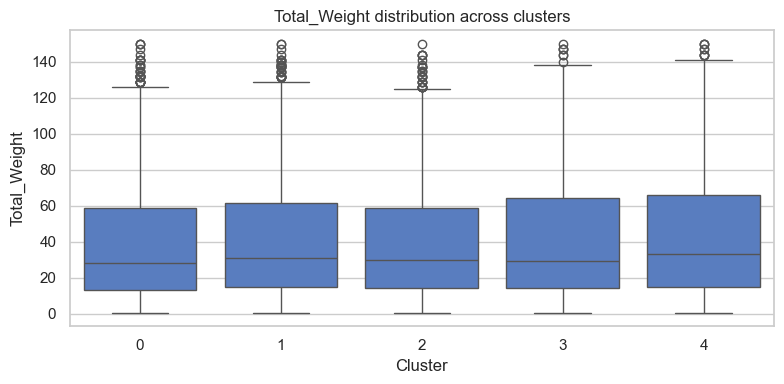

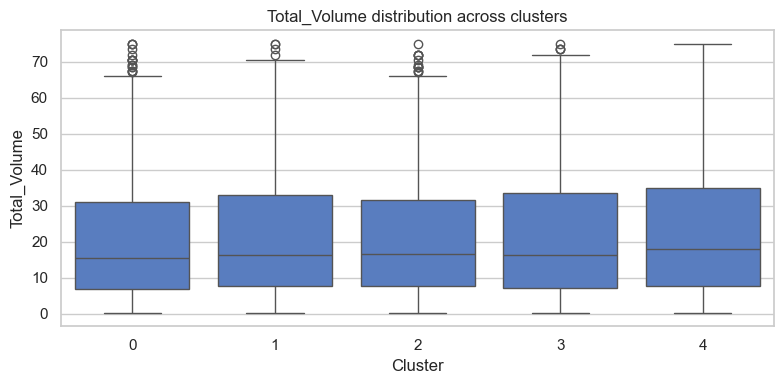

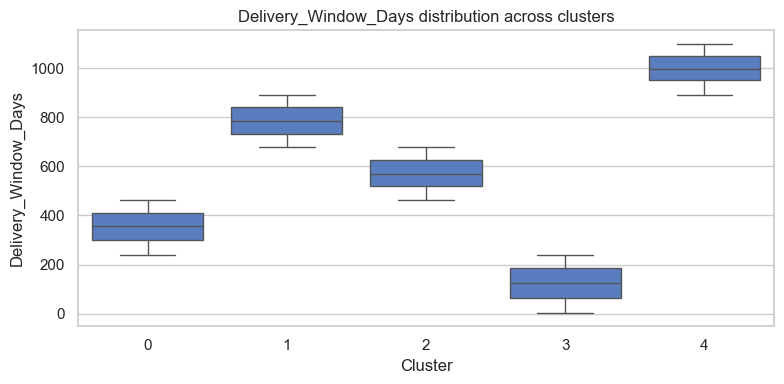

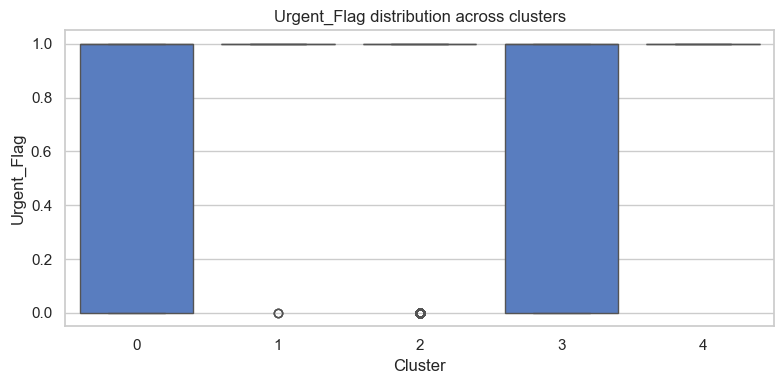

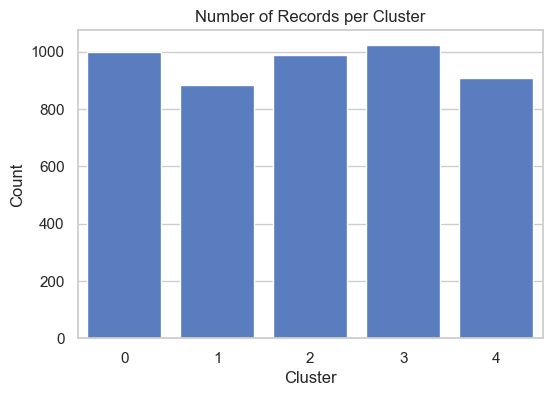

In [47]:
#CLUSTER DATA ANALYTICS

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure cluster column exists
assert "ML_Cluster_Label" in result_df.columns, "Cluster labels not found in DataFrame"

# Set plot style
sns.set(style="whitegrid", palette="muted")

# Define columns to analyze
features_to_plot = ["Total_Weight", "Total_Volume", "Delivery_Window_Days", "Urgent_Flag"]

# Plot boxplots for each feature grouped by cluster
for feature in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x="ML_Cluster_Label", y=feature, data=result_df)
    plt.title(f"{feature} distribution across clusters")
    plt.xlabel("Cluster")
    plt.ylabel(feature)
    plt.tight_layout()
    plt.show()

# Optional: Cluster count
cluster_counts = result_df["ML_Cluster_Label"].value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values)
plt.title("Number of Records per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()
